In [1]:
import networkx as nx
import math
import random
import numpy as np
from copy import deepcopy 
from matplotlib import pyplot as plt

In [2]:
def euclidean_distance(a_x, a_y, b_x, b_y):
    return math.sqrt((a_x - b_x)**2 + (a_y - b_y)**2)

In [3]:
def read_graph(file_path):
    with open(file_path) as f:
        g = nx.Graph()
        for line in f:
            if not line[0].isdigit():
                continue
            node, x, y = line.split()
            node = int(node) - 1
            x = float(x)
            y = float(y)
            g.add_node(node, x=x, y=y)
        
        for u in g.nodes:
            for v in range(u + 1, len(g.nodes)):
                g.add_edge(u, v,
                           distance=euclidean_distance(g.nodes[u]['x'],
                                                        g.nodes[u]['y'],
                                                        g.nodes[v]['x'],
                                                        g.nodes[v]['y']))
        
        return g

In [4]:
graph = read_graph("wi29.tsp")

In [5]:
graph[0][1]["distance"]

74.53561415712697

In [6]:
graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28))

In [7]:
def foo(path, g):
    length = 0
    for node in range(len(path) - 1):
        length += g[node][node + 1]["distance"]
        print(node, node + 1, g[node][node+1]["distance"])
    length += g[path[len(path)-1]][path[0]]["distance"]
    return length

In [8]:
foo([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], graph)

0 1 74.53561415712697
1 2 4069.7051490249282
2 3 1172.3669941144244
3 4 816.6666999999998
4 5 1533.3333000000002
5 6 3416.829291576882
6 7 1233.3333648648647
7 8 1586.4880519212525
8 9 3285.3631816825923
9 10 106.7186696152543
10 11 1411.95293791574
11 12 1314.2382487374398
12 13 1321.7628393130476
13 14 2350.1598668908555
14 15 3950.03516172817
15 16 2220.6731024123696
16 17 683.3332682926836
17 18 432.69187394470464
18 19 2174.409273291893
19 20 1399.5767871810572
20 21 370.5605639341698
21 22 220.14199962751314
22 23 3370.025289028461
23 24 620.2598281723953
24 25 1333.3333000000002
25 26 1400.396770760187
26 27 2023.542026854013
27 28 592.9399890054054


52284.07138604786

In [9]:
# kodiranje
# fitness
# ukrstanje
# selekcija
# mutacija

In [10]:
class Individual:
    def __init__(self, g):
        num_cities = len(g.nodes)
        self.code = np.random.permutation(num_cities).tolist()
        self.fitness = self.calc_fitness(g)
        
        
    def calc_fitness(self,g):
        length = 0
        n = len(self.code)
        for i in range(n-1):
            length += g[self.code[i]][self.code[i+1]]["distance"]
        length += g[self.code[-1]][self.code[0]]["distance"]
        return length
    
    def __lt__(self, other):
        return self.fitness < other.fitness

In [11]:
i = Individual(graph)

In [12]:
i.fitness

94520.6906195102

In [13]:
graph[27][28]["distance"]

592.9399890054054

In [14]:
len(i.code)

29

In [15]:
#TODO: benchmark algorithm, using vns for every individual, using vns only for the best individual of every generation
# compare those results

In [16]:
#for now, tournament selection
def selection(population, tournament_size,forbidden=None):
    allowed = list(set(range(len(population))).difference({forbidden}))
    chosen_indices = random.sample(allowed, tournament_size)
    best_fitness = float('inf')
    winner = None
    for index in chosen_indices:
        if best_fitness > population[index].fitness:
            winner = population[index]
            best_fitness = winner.fitness
    return winner

In [17]:
def crossover(parent1, parent2):
    
    n = len(parent1.code)
    child1 = []
    child2 = []
    
    breakpoint = random.randrange(n)
    
    child1.extend(parent1.code[:breakpoint])
    child2.extend(parent2.code[:breakpoint])
    
    for city in parent2.code:
        if city not in child1:
            child1.append(city)
    for city in parent1.code:
        if city not in child2:
            child2.append(city)
            
    return child1, child2

In [18]:
def mutation(child, mutation_prob):
    
    p = random.random()
    # try using while instead of if
    if p <= mutation_prob:
        n = len(child.code)
        random_index1 = random.randrange(n)
        allowed = list(set(range(n)).difference({random_index1}))
        random_index2 = random.choice(allowed)
        child.code[random_index1], child.code[random_index2] = child.code[random_index2], child.code[random_index1]
    

In [19]:
def shaking(solution, k):
    n = len(solution)
    chosen_cities = random.sample(range(n), 2*k)
    new_solution = deepcopy(solution)
    m = len(chosen_cities)
    for i in range(0, m, 2):
        new_solution[i], new_solution[i+1] = new_solution[i+1], new_solution[i]
        
    return new_solution

def shaking2(solution, k):
    n = len(solution)
    new_solution = deepcopy(solution)
    for _ in range(k):
        i, j = random.sample(range(n), 2)
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    
    return new_solution
        

In [20]:
def vns(individual, max_k, max_iter, move_prob):
    
    new_individual = Individual(graph)
    solution = deepcopy(individual.code)
    value = individual.fitness
    
    for i in range(max_iter):
        for k in range(max_k):
            new_solution = shaking2(solution, k)
            new_individual.code = new_solution
            
            new_individual.fitness = new_individual.calc_fitness(graph)
            new_value = new_individual.fitness
            if new_value < value or (new_value == value and random.random() < move_prob):
                value = new_value
                solution[:] = new_solution[:]
        
    individual.code[:] = solution[:]
    individual.fitness = value

In [21]:
i1 = Individual(graph)
# i1.code = [8, 6, 3, 4, 0, 1, 5, 7, 12, 14, 17, 20, 25, 15, 13, 10, 9, 11, 18, 21, 22, 28, 19, 23, 26, 24, 27, 16, 2]
# i1.fitness = i1.calc_fitness(graph)
print(i1.code)
print(i1.fitness)
print()
vns(i1, 10, 100, 0.5)
print(i1.code)
print(i1.fitness)


[5, 20, 14, 6, 21, 27, 10, 17, 7, 15, 11, 16, 28, 19, 4, 24, 9, 18, 13, 0, 25, 26, 8, 23, 1, 12, 3, 22, 2]
130857.81645427541

[22, 11, 7, 10, 9, 2, 3, 4, 15, 23, 25, 27, 19, 26, 24, 20, 18, 12, 5, 0, 1, 6, 8, 14, 21, 28, 17, 13, 16]
52098.86024402786


In [22]:
def ga_vns(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    for _ in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size, parent1)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            #mutation
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #TODO: vns
            vns(new_population[i], 2, 10, 0.5)
            vns(new_population[i+1], 2, 10, 0.5)
            
            
            #replace_population
        vns(population[0], 3, 15, 0.5)
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(num_iters), tmp)
    
    

code: [2, 3, 4, 0, 1, 5, 7, 11, 9, 10, 14, 18, 17, 21, 22, 20, 28, 27, 25, 24, 26, 23, 15, 19, 16, 13, 12, 8, 6]
fitness: 28521.047356418727


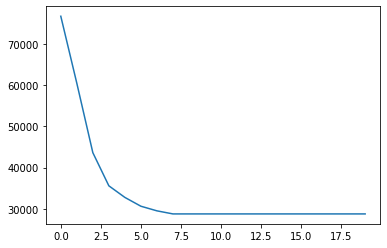

In [23]:
ga_vns( graph,
    num_iters = 20,
    use_elitism = True,
    population_size = 1000,
    elitism_size = 10,
    mutation_prob = 0.15,
    tournament_size = 10,
    )

In [24]:
def ga(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    for _ in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size, parent1)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            #mutation
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #TODO: vns
#             vns(new_population[i], 3, 10, 0.5)
#             vns(new_population[i+1], 3, 10, 0.5)
            
            
            #replace_population
        vns(population[0], 3, 10, 0.5)
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")
    
    plt.plot(range(num_iters), tmp)
    
    

code: [16, 19, 24, 26, 23, 15, 25, 27, 22, 17, 20, 28, 21, 18, 14, 12, 8, 6, 2, 3, 7, 11, 9, 10, 5, 1, 0, 4, 13]
fitness: 32876.04228031326


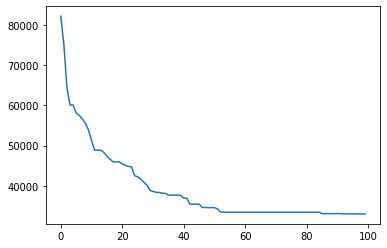

In [25]:
ga( graph,
    num_iters = 100,
    use_elitism = True,
    population_size = 100,
    elitism_size = 10,
    mutation_prob = 0.1,
    tournament_size = 5,
    )